# Pipeline test with osmFISH - Version 1

**Notes:**

- Taking a pause from this pipeline test to focus on the manuscript
- Got as far as attempting to automatically generate crops
    - When we return to this, we should try to incorporate manual editing of automatic crops
- Used just one osmFISH test image (which is also the sample image)

**Pipeline:**

- Inputs:
    - 1 osm FISH sample and test image
    - expert annotations of the image
- Operations: 
    - **Part 1**: parameter extraction from sample image
    - **Part 2**: blob detection on test images, using parameter extraction
    - **Part 3**: cropping of test images, using parameter extraction
    - **Part 4**: QC and reassembly of turker-annotated crops
    - **Part 5**: evaluation of precision and recall
- Outputs:
    - Consensus turker annotation coordinates
    - Precision and recall analysis
    

In [1]:
from math import floor, sqrt
from scipy import ndimage, optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.neighbors import KDTree
from numpy import pi, r_
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math, random, sys, os
sys.path.insert(0, '../../../FISH-annotation/Annotation')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

## User-determined parameters

In [2]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 4
max_num_crops = 7
num_partitions = 5
colors = ['red', 'orange', 'black', 'green', 'blue', 'purple', 'cyan']

# Part 1: Parameter Extraction

### This section of the pipeline:

- Inputs:
    - sample FISH image
    - expert annotations of the image
- Outputs: 
    - parameters specific to RCA FISH for blob detection
        - max sigma: `sigma_max`
        - optimal intensity threshold: `best_threshold`

### Metadata for sample image

In [3]:
sample_img_filename = 'single_plane_filtered.png'
sample_img_path = os.getcwd() + '/sample_image/' + sample_img_filename

sample_coords_filename = 'single_plane_filtered.csv'
sample_coords_path = os.getcwd() + '/sample_image/' + sample_coords_filename

### Read in the image and the expert annotations

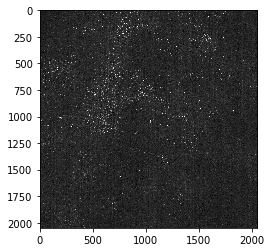

In [6]:
im = imread(sample_img_path)
im = rgb2gray(im)
plt.imshow(im, cmap='gray')
plt.show()

img_height = len(im)
ref_coords = np.genfromtxt(sample_coords_path, delimiter=',')[1:]
ref_kdt = util.csv_to_kdt(sample_coords_path, img_height)

# Find the sigma_max (the greatest spot size)

### Gaussian fit methods
Cell below from https://scipy-cookbook.readthedocs.io/items/FittingData.html.

In [7]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

### Find the size of each spot identified by the expert and take the max

In [8]:
sigma_max_list = []
for x, y in ref_coords:

    x_min = int(x)-margin if int(x)-margin >= 0 else 0
    x_max = int(x)+margin if int(x)+margin < im.shape[1] else im.shape[1]-1
    y_min = int(y)-margin if int(y)-margin >= 0 else 0
    y_max = int(y)+margin if int(y)+margin < im.shape[0] else im.shape[0]-1

    crop = im[y_min:y_max, x_min:x_max]
    params = fitgaussian(crop)
    fit = gaussian(*params)
    (height, x_param, y_param, width_x, width_y) = params
    sigma_max = math.sqrt(max(width_x, width_y)/2)
    sigma_max_list.append(sigma_max)
max_sigma = max(sigma_max_list)

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


In [9]:
print('greatest spot_sigma = %f' % (sigma_max))

greatest spot_sigma = 1.232803


# Find the optimal intensity threshold

### Assign a range of intensity thresholds to test.

In [23]:
thresholds = np.arange(0.02, 0.30, 0.01)

### Run blob detection with a range of thresholds and evaluate precision and recall overall.

In [24]:
best_precision_x_recall = 0
precision_list = []
recall_list = []
for threshold in thresholds:
    
    print('Threshold = %f' % round(threshold, 2))
    
    blobs_log = blob_log(im, max_sigma=10, num_sigma=10, threshold=threshold)
    blobs = []
    for r, c, sigma in blobs_log:
        blobs.append([c, r])
    blobs_kdt = KDTree(blobs, leaf_size=2, metric='euclidean')	# kdt is a kd tree with all the reference points

    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)

    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []

    # correct vs. incorrect

    for r, c, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))

    # detected vs. undetected

    for x, y in ref_coords:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])

    # calculate precision and recall and see if this is the best precision_x_recall we've found yet

    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    if (precision * recall) > best_precision_x_recall:
        best_precision_x_recall = precision * recall
        best_precision = precision
        best_recall = recall
        best_threshold = threshold
    precision_list.append(precision)
    recall_list.append(recall)

Threshold = 0.020000
Threshold = 0.030000
Threshold = 0.040000
Threshold = 0.050000
Threshold = 0.060000
Threshold = 0.070000
Threshold = 0.080000
Threshold = 0.090000
Threshold = 0.100000
Threshold = 0.110000
Threshold = 0.120000
Threshold = 0.130000
Threshold = 0.140000
Threshold = 0.150000
Threshold = 0.160000
Threshold = 0.170000
Threshold = 0.180000
Threshold = 0.190000
Threshold = 0.200000
Threshold = 0.210000
Threshold = 0.220000
Threshold = 0.230000
Threshold = 0.240000
Threshold = 0.250000
Threshold = 0.260000
Threshold = 0.270000
Threshold = 0.280000
Threshold = 0.290000


Text(0.5,1,'Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

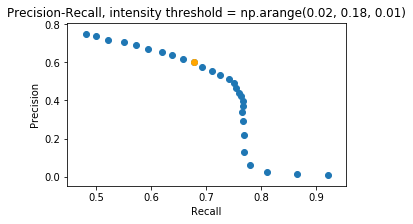

In [25]:
plt.figure(figsize = (5, 3))
plt.scatter(recall_list, precision_list)
plt.scatter([best_recall], [best_precision], c='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall, intensity threshold = np.arange(0.02, 0.18, 0.01)')

Text(0.5,1,'Precision * Recall')

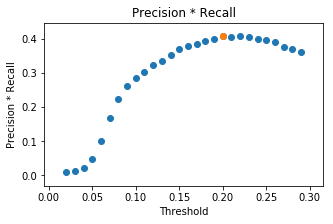

In [30]:
plt.figure(figsize = (5, 3))
precision_x_recall = [p*r for p, r in zip(precision_list, recall_list)]
plt.scatter(thresholds, precision_x_recall)
plt.scatter([thresholds[precision_x_recall.index(max(precision_x_recall))]], [max(precision_x_recall)])
# plt.scatter([best_recall], [best_precision], c='orange')
plt.xlabel('Threshold')
plt.ylabel('Precision * Recall')
plt.title('Precision * Recall')

In [27]:
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))

optimal intensity threshold = 0.200000


### The max sigma and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.

In [28]:
print('greatest spot_sigma = %f' % (round(sigma_max, 2)))
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))

greatest spot_sigma = 1.230000
optimal intensity threshold = 0.200000


# Part 2: Blob Detection

### This section of the pipeline:

- Inputs:
    - parameters specific to RCA FISH for blob detection
        - max sigma: `sigma_max`
        - optimal intensity threshold: `best_threshold`
- Outputs:
    - coordinates of spots detected by blob detection: `blobs` (in `blobs_list`)

### Paths to test images and coords

In [63]:
test_img_filenames = ['single_plane_filtered']
test_img_paths = [os.getcwd() + '/test_images/images/%s.png' % x for x in test_img_filenames]
test_coords_paths = [os.getcwd() + '/test_images/coords/%s.csv' % x for x in test_img_filenames]

### View sample images

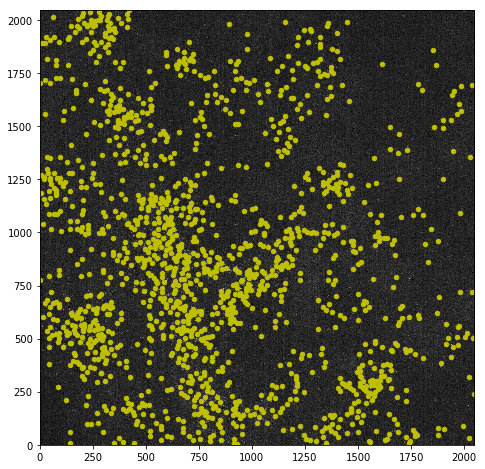

In [64]:
for img_path, coords_path in zip(test_img_paths, test_coords_paths):
    im = imread(img_path)
    im_gray = rgb2gray(im)
    plt.figure(figsize=(12, 8))
    plt.imshow(im_gray, cmap='gray')
    # show ref coords for test images
    ref_coords = np.genfromtxt(coords_path, delimiter=',')
    for x, y in ref_coords[1:]:
        plt.scatter([x], [y], s=20, c='y')
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.show()

### Run blob_log() on all test images using sigma_max and best_threshold found above.

In [65]:
precision_list = []
recall_list = []
sort_list = []
blobs_list = []

# For each test image
for img_path, coords_path in zip(test_img_paths, test_coords_paths):
    im = imread(img_path)
    im_gray = rgb2gray(im)
    img_height = len(im)  
    ref_coords = np.genfromtxt(coords_path, delimiter=',')
    ref_kdt = util.csv_to_kdt(coords_path, img_height)
    
    blobs_log = blob_log(im, max_sigma=sigma_max, num_sigma=10, threshold=best_threshold)
    blobs = [[c, r] for r, c, z, sigma in blobs_log]
    blobs_list.append(blobs)
    blobs_kdt = KDTree(blobs, leaf_size=2, metric='euclidean')
    
    num_blobs_total = len(blobs_log)
    num_ref_total = len(ref_coords)
    
    correct_blobs = []
    incorrect_blobs = []
    detected_ref = []
    undetected_ref = []
    
    # correct vs. incorrect
    
    for r, c, z, sigma in blobs_log:
        dist, ind = ref_kdt.query([[c, img_height-r]], k=1)
        if dist[0][0] < correctness_threshold:
            correct_blobs.append((r, c, sigma))
        else:
            incorrect_blobs.append((r, c, sigma))
    
    # detected vs. undetected
    
    for x, y in ref_coords[1:]:
        dist, ind = blobs_kdt.query([[x, y]], k=1)
        if dist[0][0] < correctness_threshold:
            detected_ref.append([x, y])
        else:
            undetected_ref.append([x, y])
    
    sort_list.append((correct_blobs, incorrect_blobs, detected_ref, undetected_ref))
    
    # calculate precision and recall
    
    precision = len(correct_blobs)/(len(correct_blobs)+len(incorrect_blobs))
    recall = len(detected_ref)/(len(detected_ref)+len(undetected_ref))
    
    precision_list.append(precision)
    recall_list.append(recall)

### Plot Correct vs. Incorrect, Detected vs. Undetected

Intensity threshold = 0.200000


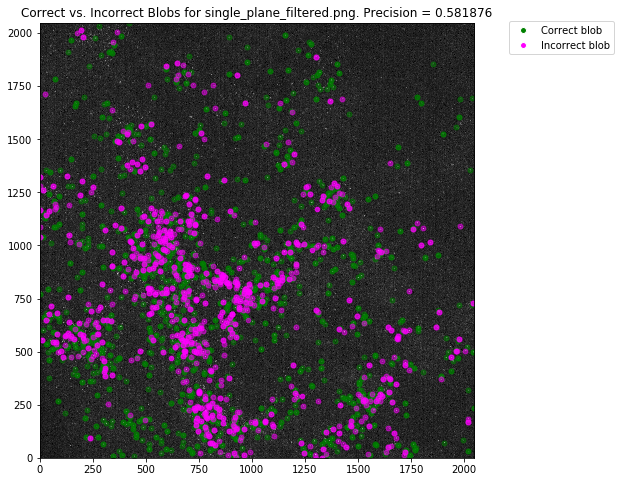

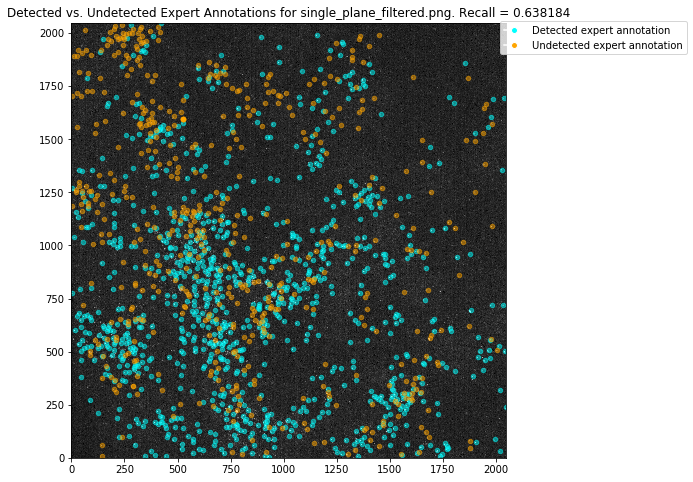

In [66]:
print('Intensity threshold = %f' % best_threshold)
    
for sort, img_name, img_path, precision, recall in zip(sort_list, test_img_filenames, test_img_paths, precision_list, recall_list):
    
    correct_blobs, incorrect_blobs, detected_ref, undetected_ref = sort
    im = imread(img_path)
    im_gray = rgb2gray(im)
    
    # plot correct vs. incorrect

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for r, c, sigma in correct_blobs:
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c='green')
    for r, c, sigma in incorrect_blobs:
        plt.scatter([c], [r], alpha=0.5, s=int(sigma*20), c='magenta')

    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='green', label='Correct blob'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Incorrect blob')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))
    plt.title('Correct vs. Incorrect Blobs for %s.png. Precision = %f' % (img_name, precision))
    plt.show()
    
    # plot detected vs. undetected

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for x, y in detected_ref:
        plt.scatter([x], [y], alpha=0.5, s=20, c='cyan')
    for x, y in undetected_ref:
        plt.scatter([x], [y], alpha=0.5, s=20, c='orange')
    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Detected expert annotation'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='orange', label='Undetected expert annotation')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))	
    plt.title('Detected vs. Undetected Expert Annotations for %s.png. Recall = %f' % (img_name, recall))
    plt.show()
    

# Part 3: Cropping

### This section of the pipeline:

- Inputs:
    - coordinates of spots detected by blob detection: `blobs` (in `blobs_list`)
- Outputs:
    - crops ready to be sent to mechanical turkers

In [67]:
def get_nnd(coord, kdt):
    dist, ind = kdt.query([coord], k=2)
    return dist[0][1]

crosshair_arm_to_image_width_ratio = 0.03045   # measured empirically in Quantius's UI

### Step 1: ID crowded spots

crowded blobs / total blobs = 2492 / 2516 = 0.990461


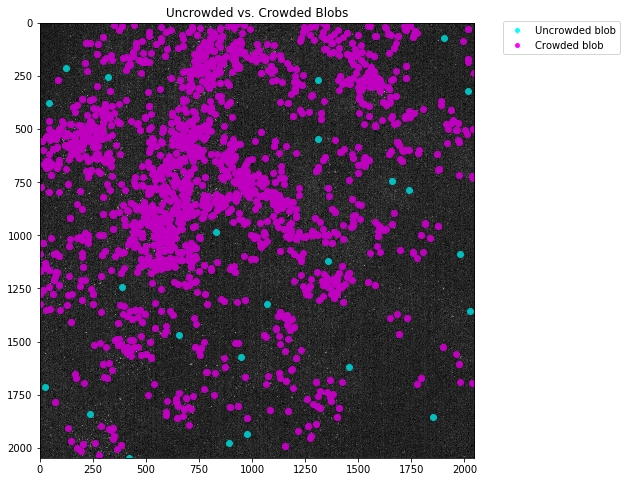

In [68]:
crowded_blobs_list = []
kdt_list = []
for blobs, img_path in zip(blobs_list, test_img_paths):
    kdt = KDTree(blobs, leaf_size=2, metric='euclidean')
    kdt_list.append(kdt)
    im = imread(img_path)
    img_width = len(im[0])
    
    crosshair_arm_length = crosshair_arm_to_image_width_ratio * img_width
    
    plt.figure(figsize = (12, 8))
    close_distances = []
    crowded_blobs = []
    for coord in blobs:
        nnd = get_nnd(coord, kdt)
        if nnd < crosshair_arm_length:
            close_distances.append(nnd)
            crowded_blobs.append(coord)
            plt.scatter(coord[0], coord[1], facecolors = 'm')
        else:
            plt.scatter(coord[0], coord[1], facecolors = 'c')
    crowded_blobs_list.append(crowded_blobs)

    s = 'crowded blobs / total blobs = %d / %d = %f' % (len(crowded_blobs), len(blobs), float(len(crowded_blobs))/len(blobs))
    print(s)
    
    plt.title('Uncrowded vs. Crowded Blobs')
    plt.imshow(im, cmap='gray')
    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Uncrowded blob'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Crowded blob')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))
    plt.show()

### Step 2: Bound regions with many crowded spots.

Apply clustering or partitioning algorithm to crowded spots to separate out regions with many crowded spots.

Use hybrid approach: AffinityPropagation, then K-means

(This code block also collects all cluster members into `collect_cluster_members_lists`. Each element of `collect_cluster_members_lists` contains the lists of clusters and their members associated with one image.)

In [69]:
np.savetxt('blobs.csv', blobs, delimiter=",", comments='')

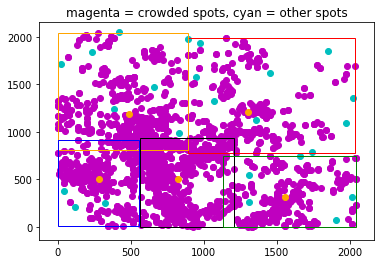

In [70]:
crop_bounds_list = []
for crowded_blobs, blobs, kdt in zip(crowded_blobs_list, blobs_list, kdt_list):
    
    # First try AffinityPropagaion, adjusting the preference parameter
    num_centers = max_num_crops + 1
    pref_param = -500
    crowded_coords = np.asarray(crowded_blobs)
    for _ in range(5):
        af = AffinityPropagation(preference = pref_param).fit(crowded_coords)
        centers = [crowded_coords[index] for index in af.cluster_centers_indices_]
        num_centers = len(centers)
        cluster_members_lists = [[] for i in range(len(centers))]
        for label_index, coord in zip(af.labels_, crowded_coords):
            cluster_members_lists[label_index].append(coord)
        pref_param *= 10
        if num_centers <= max_num_crops:
            break
    
    # If still too many clusters, partition using K-means
    if num_centers > max_num_crops:
        km = KMeans(n_clusters = num_partitions).fit(crowded_coords)
        centers = km.cluster_centers_
        cluster_members_lists = [[] for i in range(len(centers))]
        for label_index, coord in zip(km.labels_, crowded_coords):
            cluster_members_lists[label_index].append(coord)
        
    crop_bounds = []
    for l in cluster_members_lists:
        l = np.asarray(l)
        x = l[:,0]
        y = l[:,1]
        crop_bounds.append((min(x), max(x), min(y), max(y)))
    
    crop_bounds_list.append(crop_bounds)
    
    fig,ax = plt.subplots(1)
    for coord in blobs:
        nnd = get_nnd(coord, kdt)
        if nnd < crosshair_arm_length:
            ax.scatter(coord[0], coord[1], facecolors = 'm')
        else:
            ax.scatter(coord[0], coord[1], facecolors = 'c')
    for center in centers:
        plt.scatter(center[0], center[1], facecolors = 'orange')

    for crop, col in zip(crop_bounds, colors):
        rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor = col, facecolor = 'none')
        ax.add_patch(rect)
    plt.title('magenta = crowded spots, cyan = other spots')
    plt.show()

### Create crops.
Wherever crops overlap, only one of the crops should contain the blobs in the overlap region.

In [71]:
crops_members_lists = []

# for each of the three test images
for crops_bounds, blobs in zip(crop_bounds_list, blobs_list):
    
    # designate a bin for all "used" blobs. the same blob should not end up in multiple different crops.
    used_blobs = []
    
    # lists of blobs that will be in each crop
    crops_members = []
    
    # for each crop
    for crop_bounds in crops_bounds:
        
        # list of blobs that will be in that crop
        crop_members = []
    
        # get bounds
        min_x, max_x, min_y, max_y = crop_bounds
                
        for blob in blobs:
            x, y = blob
            if x >= min_x and x <= max_x and y >= min_y and y <= max_y:
                if blob not in used_blobs:
                    crop_members.append(blob)
                    used_blobs.append(blob)
                
        crops_members.append(crop_members)
    
    crops_members_lists.append(crops_members)

### Generate crops from the parent images, visualize.

Wherever crops overlap,  one of the crops should have the overlap region blacked out.

bb = x_min, x_max, y_min, y_max = col_min, col_max, row_min, row_max

In [72]:
crosshair_ratio = 0.029

In [73]:
def get_crop(parent_im, bb):
    return parent_im[int(bb[2]) : int(bb[3]), int(bb[0]) : int(bb[1])]

-------------------------- single_plane_filtered --------------------------
------------------ Crop #0 ------------------


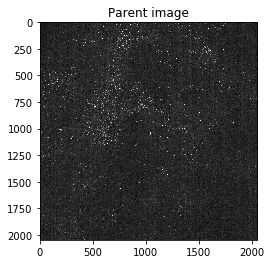

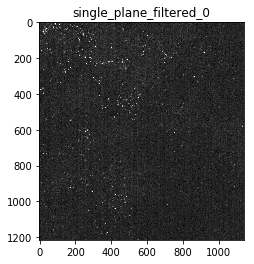

crowded blobs / total blobs = 341 / 293 = 1.163823


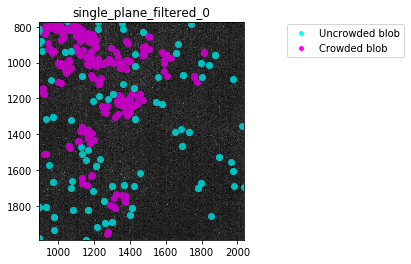

------------------ Crop #1 ------------------


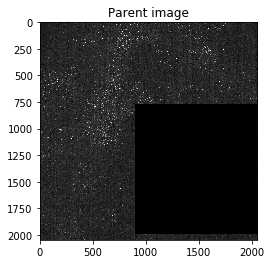

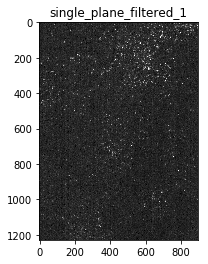

crowded blobs / total blobs = 553 / 460 = 1.202174


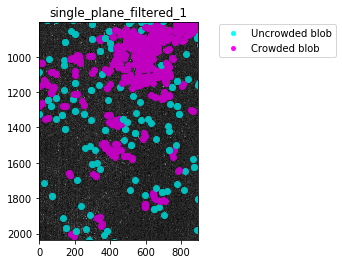

------------------ Crop #2 ------------------


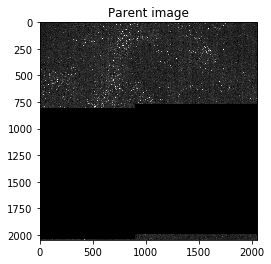

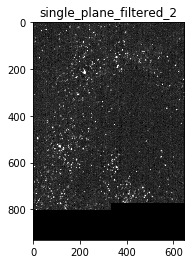

crowded blobs / total blobs = 501 / 453 = 1.105960


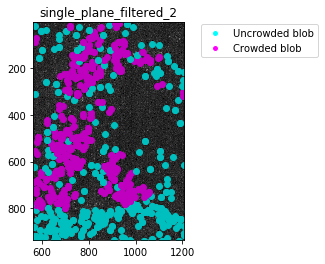

------------------ Crop #3 ------------------


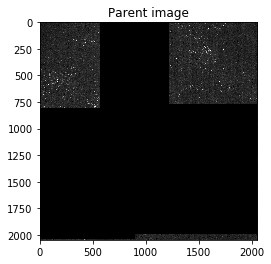

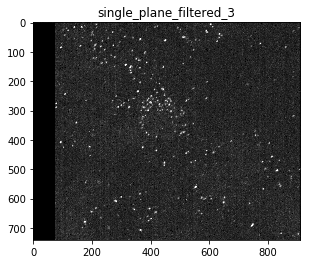

crowded blobs / total blobs = 276 / 230 = 1.200000


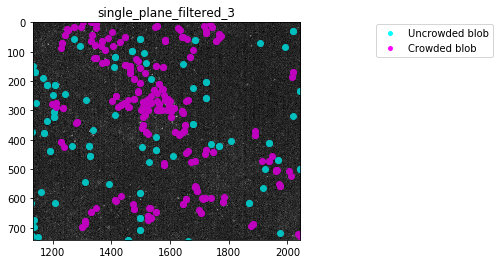

------------------ Crop #4 ------------------


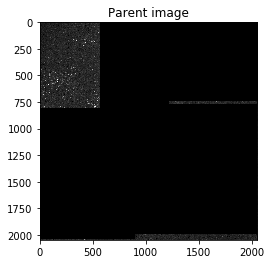

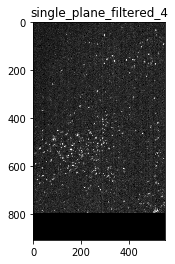

crowded blobs / total blobs = 215 / 254 = 0.846457


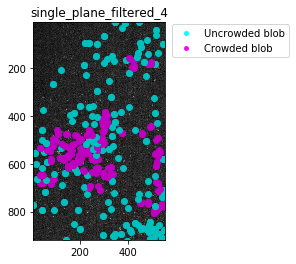

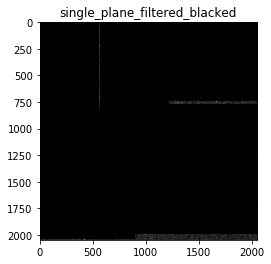

In [74]:
# for each of the test images
for crops_bounds, blobs, img_path, img_name, crops_members in zip(crop_bounds_list, blobs_list, test_img_paths, test_img_filenames, crops_members_lists):
    
    print('-------------------------- %s --------------------------' % img_name)
    parent_im = imread(img_path)
    
    for crop_index in range(len(crops_bounds)):
        print('------------------ Crop #%d ------------------' % crop_index)
        crop_bounds = crops_bounds[crop_index]
        
        crop = get_crop(parent_im, crop_bounds)
        
        new_img_name = img_name + '_' + str(crop_index)
        plt.imsave(new_img_name + '.png', crop, cmap='gray')
        np.savetxt(new_img_name + '.csv', [x for x in crop_bounds], delimiter=",", comments='')

        plt.figure()
        plt.imshow(parent_im, cmap='gray')
        plt.title('Parent image')
        plt.show()
        
        plt.figure()
        plt.imshow(crop, cmap='gray')
        plt.title(new_img_name)
        plt.show()

        for r in range(parent_im.shape[0]):
            for c in range(parent_im.shape[1]):
                if (r >= crop_bounds[2]) and (r <= crop_bounds[3]):
                    if (c >= crop_bounds[0]) and (c <= crop_bounds[1]):
                        parent_im[r][c] = 0
        
        # See what blobs in the crops are still crowded
        
        crop_members = crops_members[crop_index]
        crop_bounds = crops_bounds[crop_index]
        new_crosshair_arm_length = (crop_bounds[1] - crop_bounds[0]) * crosshair_ratio

        kdt = KDTree(crop_members, leaf_size=2, metric='euclidean')
        
        plt.figure()
        crowded_blobs = []
        for coord in blobs:
            nnd = get_nnd(coord, kdt)
            if nnd < new_crosshair_arm_length:
                crowded_blobs.append(coord)
                plt.scatter(coord[0], coord[1], facecolors = 'm')
            else:
                plt.scatter(coord[0], coord[1], facecolors = 'c')

        s = 'crowded blobs / total blobs = %d / %d = %f' % (len(crowded_blobs), len(crop_members), float(len(crowded_blobs))/len(crop_members))
        print(s)

        plt.title(new_img_name)
        plt.imshow(im, cmap='gray')
        handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Uncrowded blob'),
                      Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Crowded blob')]
        plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.5, 1.015))
        plt.xlim(crop_bounds[0], crop_bounds[1])
        plt.ylim(crop_bounds[2], crop_bounds[3])
        plt.gca().invert_yaxis()
        plt.show()
              
    plt.figure()
    plt.imshow(parent_im, cmap='gray')
    plt.title(img_name + '_blacked')
    plt.show()
    plt.imsave(img_name + '_blacked.png', parent_im, cmap='gray')


# Part 4: QC and Reassembly

### This section of the pipeline:

- Inputs:
    - crops annotated by turkers
- Outputs:
    - spot coordinates for original parent image

#### Temp: Grab necessary data again

In [3]:
sample_img_filename = 'RCA.png'
sample_img_path = os.getcwd() + '/sample_image/' + sample_img_filename

sample_coords_filename = 'rca.csv'
sample_coords_path = os.getcwd() + '/sample_image/' + sample_coords_filename

test_img_filenames = ['ISS_rnd0_ch1_z0', 'ISS_rnd0_ch3_z0', 'ISS_rnd1_ch1_z0']
test_img_paths = [os.getcwd() + '/test_images/images/%s.png' % x for x in test_img_filenames]
test_coords_paths = [os.getcwd() + '/test_images/coords/%s.csv' % x for x in test_img_filenames]
num_crops_list = [5, 3, 7]

## Cluster and QC for each crop, save coords as csv files

### Params

In [5]:
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]

In [4]:
quantiusresults_path = os.getcwd() + '/rca_test_crops_v4/quantiusresults/'
result_clusters_all_images = []

# for each test image
for test_img_filename, img_path, coords_path, num_crops in zip(test_img_filenames, test_img_paths, test_coords_paths, num_crops_list):
    json_filepath = quantiusresults_path + test_img_filename + '.json'
    
    result_clusters_all_crops = []
    
    crop_filenames = [test_img_filename + '_blacked.png']
    
    # for each crop
    for crop_index in range(num_crops):
        crop_filenames.append(test_img_filename + '_' + str(crop_index) + '.png')
        
    for crop_filename in crop_filenames:
        print(crop_filename)
        
        # Read annotations and cluster
        print('\tReading and clustering...')
        qa = QuantiusAnnotation(json_filepath, crop_filename)
        sa = SpotAnnotationAnalysis(qa)
        anno_all = qa.df()
        clusters = sa.get_clusters(anno_all, clustering_params)
        
        # QC
        print('\tQC...')
        cluster_size_threshold = util.get_cluster_size_threshold(clusters)
        small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
        
        clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
        clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
        
        result_clusters = nonclumpy_clusters
        for i in range(len(clumpy_clusters.index)):
            subclusters = util.declump(clumpy_clusters, i, declumping_params)
            result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)
            
        print('\tnum clusters found: ', len(result_clusters.index))    
        result_clusters_all_crops.append(result_clusters)
    result_clusters_all_images.append(result_clusters_all_crops)
        

## Reassemble centroids

In [3]:
totals = []

# for each test image
for test_img_filename, test_img_path, coords_path, num_crops, result_clusters_all_crops in zip(test_img_filenames, test_img_paths, test_coords_paths, num_crops_list, result_clusters_all_images):
    
    im = imread(test_img_path)
    im = rgb2gray(im)
    img_height = len(im)
    total = []
    
    # from blacked crop
    coords_blacked = np.asarray(result_clusters_all_crops[0])
    for coord in coords_blacked:
        plt.scatter(coord[0], img_height-coord[1], color = 'black')
        total.append([coord[0], img_height-coord[1]])

    # from other crops
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'violet', 'magenta']    
    for i, result_clusters in zip(range(num_crops), result_clusters_all_crops[1:]):
        
        csv_path = os.getcwd() + '/rca_test_crops_v4/crop_metadata/' + test_img_filename + '_' + str(i) + '.csv'
        stats = np.asarray(pd.read_csv(csv_path, header = None))
        xmin = stats[0][0]
        ymin = stats[2][0]
        ymax = stats[3][0]
        height = ymax - ymin

        refit = []
        for coord in np.asarray(result_clusters):
            x = coord[0] + xmin
            y = height - coord[1] + ymin
            refit.append([x, y])
            total.append([x, y])
        refit = np.asarray(refit)

        for coord in refit:
            plt.scatter(coord[0], coord[1], color = colors[i])
            
    plt.title(test_img_filename)
    plt.show()
    
    totals.append(total)

### Save total consensus coords for each test image

In [131]:
os.mkdir('total_consensus_coords')
for total, test_img_filename in zip(totals, test_img_filenames):
    total_consensus_coords_path = 'total_consensus_coords/' + test_img_filename + '.csv'
    print(total_consensus_coords_path)
    np.savetxt(total_consensus_coords_path, total, delimiter=",", comments='', header = "centroid_x,centroid_y")

total_consensus_coords/ISS_rnd0_ch1_z0.csv
total_consensus_coords/ISS_rnd0_ch3_z0.csv
total_consensus_coords/ISS_rnd1_ch1_z0.csv


# Part 5: Evaluation

## This section of the pipeline calculates and visualizes precision and recall.

### Calculate precision and recall: Worker annotations vs. Expert annotations

In [5]:
sort_list = []
precision_list = []
recall_list = []

# for each test image
for test_img_filename in test_img_filenames:
    
    total_consensus_coords_path = 'total_consensus_coords/' + test_img_filename + '.csv'
    consensus_coords = np.asarray(pd.read_csv(total_consensus_coords_path))
    
    expert_anno_filepath = os.getcwd() + '/test_images/coords_v2/' + test_img_filename + '.csv'
    expert_coords = np.asarray(pd.read_csv(expert_anno_filepath))
    
    expert_kdt = KDTree(expert_coords, leaf_size=2, metric='euclidean')
    consensus_kdt = KDTree(consensus_coords, leaf_size=2, metric='euclidean')
    
    correct_consensus = []
    incorrect_consensus = []
    detected_expert = []
    undetected_expert = []
    
    # correct vs. incorrect
    
    for consensus_coord in consensus_coords:
        dist, ind = expert_kdt.query([consensus_coord], k=1)
        if dist[0][0] < correctness_threshold:
            correct_consensus.append(consensus_coord)
        else:
            incorrect_consensus.append(consensus_coord)
    
    # detected vs. undetected
    
    for expert_coord in expert_coords:
        dist, ind = consensus_kdt.query([expert_coord], k=1)
        if dist[0][0] < correctness_threshold:
            detected_expert.append(expert_coord)
        else:
            undetected_expert.append(expert_coord)

    sort_list.append((correct_consensus, incorrect_consensus, detected_expert, undetected_expert))
    precision_list.append(float(len(correct_consensus))/len(consensus_coords))
    recall_list.append(float(len(detected_expert))/len(expert_coords))


### Visualize precision and recall

In [1]:
for sort, precision, recall, test_img_path, test_img_filename in zip(sort_list, precision_list, recall_list, test_img_paths, test_img_filenames):
    
    correct_consensus, incorrect_consensus, detected_expert, undetected_expert = sort
    im = imread(test_img_path)
    im_gray = rgb2gray(im)
    
    # plot correct vs. incorrect

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for x, y in correct_consensus:
        plt.scatter([x], [y], alpha=0.5, s=20, c='green')
    for x, y in incorrect_consensus:
        plt.scatter([x], [y], alpha=0.5, s=20, c='magenta')

    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='green', label='Correct'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Incorrect')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))
    precision = float(len(correct_consensus))/(len(correct_consensus)+len(incorrect_consensus))
    plt.title('Correct vs. Incorrect Consensus Coordinates for %s.png. Precision = %f' % (test_img_filename, precision))
    plt.show()
    
    # plot detected vs. undetected

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for x, y in detected_expert:
        plt.scatter([x], [y], alpha=0.5, s=20, c='cyan')
    for x, y in undetected_expert:
        plt.scatter([x], [y], alpha=0.5, s=20, c='orange')
    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Detected'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='orange', label='Undetected')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))	
    plt.title('Detected vs. Undetected Expert Annotations for %s.png. Recall = %f' % (test_img_filename, recall))
    plt.show()
    
    
    

### Visualize precision and recall, showing reference points

In [2]:
for sort, precision, recall, test_img_path, test_img_filename in zip(sort_list, precision_list, recall_list, test_img_paths, test_img_filenames):
    
    correct_consensus, incorrect_consensus, detected_expert, undetected_expert = sort
    im = imread(test_img_path)
    im_gray = rgb2gray(im)
    
    # plot correct vs. incorrect

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for x, y in correct_consensus:
        plt.scatter([x], [y], alpha=0.5, s=20, c='green')
    for x, y in incorrect_consensus:
        plt.scatter([x], [y], alpha=0.5, s=20, c='magenta')
    expert = detected_expert + undetected_expert
    for x, y in expert:
        plt.scatter([x], [y], alpha=0.5, s=10, c='yellow')

    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='green', label='Correct'),
                   Line2D([0],[0], marker='o', color='w', markerfacecolor='magenta', label='Incorrect'),
                   Line2D([0],[0], marker='o', color='w', markerfacecolor='yellow', label='Expert')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))
    precision = float(len(correct_consensus))/(len(correct_consensus)+len(incorrect_consensus))
    plt.title('Correct vs. Incorrect Consensus Coordinates for %s.png. Precision = %f' % (test_img_filename, precision))
    plt.show()
    
    # plot detected vs. undetected

    plt.figure(figsize=(12, 8))
    plt.xlim(0, len(im[0]))
    plt.ylim(0, len(im))
    plt.imshow(im_gray, cmap='gray')
    for x, y in detected_expert:
        plt.scatter([x], [y], alpha=0.5, s=20, c='cyan')
    for x, y in undetected_expert:
        plt.scatter([x], [y], alpha=0.5, s=20, c='orange')
    consensus = correct_consensus + incorrect_consensus
    for x, y in consensus:
        plt.scatter([x], [y], alpha=0.5, s=10, c='yellow')
    handle_list = [Line2D([0],[0], marker='o', color='w', markerfacecolor='cyan', label='Detected'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='orange', label='Undetected'),
                  Line2D([0],[0], marker='o', color='w', markerfacecolor='yellow', label='Consensus')]
    plt.legend(handles=handle_list, loc=9, bbox_to_anchor=(1.2, 1.015))	
    plt.title('Detected vs. Undetected Expert Annotations for %s.png. Recall = %f' % (test_img_filename, recall))
    plt.show()
    